<h1>FD002 PreProcessing</h1>
<ul>
    <li>Dropping and scaling data</li>
    <li>Getting time series data</li>
    <li>Visualization of data distribution</li>
    <li>Saving preprocessed data</li>
</ul>

In [1]:
from tools import *

devices: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [2]:
prepare_dirs(task='preprocessing')

Downloading...
From: https://drive.google.com/uc?id=1LU1DQuv7_CzBy2_Abgjg3HsvNDme361O
To: D:\virtualenv\src\thesis\cmapss\preprocessing\input\CMAPSSData\CMAPSSData.zip
100%|█████████████████████████████████████████████████████████████████████████████| 12.4M/12.4M [00:01<00:00, 7.61MB/s]


Extracting CMAPSSData.zip...
Extraction complete: ./input\CMAPSSData
Input directory
'./input'
URL input dataset
'https://drive.google.com/file/d/1LU1DQuv7_CzBy2_Abgjg3HsvNDme361O/view?usp=drive_link'
Input dataset directory
'./input\\CMAPSSData'
Output directory
'./working'
Output directory
'./working'
Output data directory
'./working\\data'
Output plots directory
'./working\\plots'


In [3]:
nprint('Datasets name', datasets_name)
nprint('Dataset name', dataset_name)

# filtering and categorizing files path
categorized_files_name = filter_directory(
    directory=dataset_dir, 
    category_filters=category_filters, 
    excluded_files='.ipynb_checkpoints'
)
train_features_files_name = categorized_files_name[FileCategory.TRAIN_FEATURES]
test_features_files_name = categorized_files_name[FileCategory.TEST_FEATURES]
test_targets_files_name = categorized_files_name[FileCategory.TEST_TARGETS]
uncategorized_files_name = categorized_files_name[FileCategory.UNCATEGORIZED]
nprint("Train features files name", train_features_files_name)
nprint("Test features files name", test_features_files_name)
nprint("Test targets files name", test_targets_files_name)
nprint("Uncategorized files name", uncategorized_files_name)

train_features_name = get_dataset(name=dataset_name, files_list=train_features_files_name)
train_features_path = os.path.join(dataset_dir, train_features_name)
test_features_file_name = get_dataset(name=dataset_name, files_list=test_features_files_name)
test_features_file_path = os.path.join(dataset_dir, test_features_file_name)
test_targets_file_name = get_dataset(name=dataset_name, files_list=test_targets_files_name)
test_targets_file_path = os.path.join(dataset_dir, test_targets_file_name)

nprint('Dataset files path', [train_features_path, test_features_file_path, test_targets_file_path])

train_features_data =  pd.read_csv(train_features_path, sep=pdsep, header=None)
nprint('Train features data size', (len(train_features_data), len(train_features_data.columns)))
test_features_data = pd.read_csv(test_features_file_path, sep=pdsep, header=None)
nprint('Test features data size', (len(test_features_data), len(test_features_data.columns)))
test_targets_data = pd.read_csv(test_targets_file_path, sep=pdsep, header=None)
nprint('Test targets data size', (len(test_targets_data), len(test_targets_data.columns)))

Datasets name
['FD001', 'FD002', 'FD003', 'FD004']
Dataset name
'FD002'
Files List Name
['Damage Propagation Modeling.pdf',
 'readme.txt',
 'RUL_FD001.txt',
 'RUL_FD002.txt',
 'RUL_FD003.txt',
 'RUL_FD004.txt',
 'test_FD001.txt',
 'test_FD002.txt',
 'test_FD003.txt',
 'test_FD004.txt',
 'train_FD001.txt',
 'train_FD002.txt',
 'train_FD003.txt',
 'train_FD004.txt']
Train features files name
['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
Test features files name
['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
Test targets files name
['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']
Uncategorized files name
['Damage Propagation Modeling.pdf', 'readme.txt']
Dataset files path
['./input\\CMAPSSData\\train_FD002.txt',
 './input\\CMAPSSData\\test_FD002.txt',
 './input\\CMAPSSData\\RUL_FD002.txt']
Train features data size
(53759, 26)
Test features data size
(33991, 26)
Test targets data size
(259, 1)


In [4]:
processed_train_features = []
processed_train_targets = []
processed_test_features = []
windows_generated = []

# getting train and test engines
train_engines = train_features_data[0]
test_engines = test_features_data[0]

# getting number of train and test engines
num_train_engines = len(train_features_data[0].unique())
num_test_engines = len(test_features_data[0].unique())

<h2>Dropping and scaling data</h2>

In [5]:
# dropping redundant features
columns_to_drop = [col for col in columns_to_drop if col in train_features_data.columns]
train_features_data_colsdropped = train_features_data.drop(columns=columns_to_drop)
test_features_data_colsdropped = test_features_data.drop(columns=columns_to_drop)

# scaling data for all engines 
scaler = MinMaxScaler(feature_range=(-1,1))
train_features_data = scaler.fit_transform(train_features_data_colsdropped)
test_features_data = scaler.transform(test_features_data_colsdropped)

# stacking train and test engines with scaled features (engines should not to be scaled)
train_features_data = pd.DataFrame(data=np.c_[train_engines, train_features_data])
test_features_data = pd.DataFrame(data=np.c_[test_engines, test_features_data])

<h2>Getting time series data</h2>
<ul>
    <li>Getting time series training data</li>
    <li>Getting time series testing data</li>
</ul>

<h3>Getting time series training data</h3>

In [6]:
for i in tqdm(np.arange(1, num_train_engines + 1)):
    raw_train_features = train_features_data[train_features_data[0] == i].drop(columns = [0]).values
    raw_train_targets = cycles2rul(cycles=raw_train_features.shape[0], upper_rul=upper_rul)
    ts_train_features, ts_train_targets = raw2ts(
        raw_features=raw_train_features, 
        raw_targets=raw_train_targets, 
        window_length=window_length, 
        shift=shift
    )
    processed_train_features.append(ts_train_features)
    processed_train_targets.append(ts_train_targets)
processed_train_features = np.concatenate(processed_train_features)
processed_train_targets = np.concatenate(processed_train_targets)
# shuffling training data
index = np.random.permutation(len(processed_train_targets))
processed_train_features = processed_train_features[index]
processed_train_targets = processed_train_targets[index]

100%|███████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 974.57it/s]


<h3>Getting time series testing data</h3>

In [7]:
for i in tqdm(np.arange(1, num_test_engines + 1)):
    raw_test_features = test_features_data[test_features_data[0] == i].drop(columns = [0]).values
    ts_test_features, num_windows_generated = raw2tswindows(
        raw_features=raw_test_features, 
        window_length=window_length, 
        shift=shift,
        num_windows=num_windows
    )
    processed_test_features.append(ts_test_features)
    windows_generated.append(num_windows_generated)
processed_test_features = np.concatenate(processed_test_features)
ts_test_targets = test_targets_data[0].values

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 1408.88it/s]


<h2>Visualization of data distribution</h2>
<ul>
    <li>Training and validation data distribution</li>
    <li>Preprocessed data shapes</li>
</ul>

<h3>Training and validation data distribution</h3>

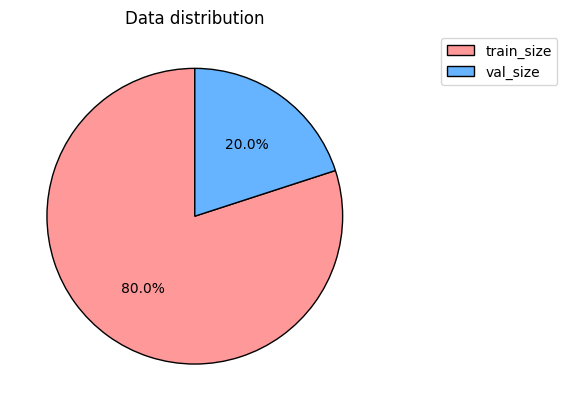

In [8]:
(processed_train_features, 
 processed_val_features, 
 processed_train_targets, 
 processed_val_targets
) = train_test_split(
     processed_train_features,
     processed_train_targets,
     test_size = val_size,
     random_state = random_state_split
)

wedges, texts, autotexts = plt.pie(
    [100-(val_size*100), val_size*100],
    colors = ['#ff9999', '#66b3ff'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.legend(
    wedges, 
    ['train_size', 'val_size'], 
    loc='best', 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Data distribution')
plt.show()

<h3>Preprocessed data shapes</h3>

In [9]:
nprint("Processed train data shape", processed_train_features.shape)
nprint("Processed train targets shape", processed_train_targets.shape)
nprint("Processed val features shape", processed_val_features.shape)
nprint("Processed val targets shape", processed_val_targets.shape)
nprint("Processed test features shape", processed_test_features.shape)
nprint("Processed test targets shape", ts_test_targets.shape)

Processed train data shape
(39055, 20, 15)
Processed train targets shape
(39055,)
Processed val features shape
(9764, 20, 15)
Processed val targets shape
(9764,)
Processed test features shape
(1289, 20, 15)
Processed test targets shape
(259,)


<h2>Saving preprocessed data</h2>
<ul>
    <li>Saving the scaler</li>
    <li>Saving of preprocessed training, validation and testing data</li>
    <li>Creation of a .zip file for uploading to Google Drive</li>
</ul>

In [10]:
preprocessed_data_dir = os.path.join(out_data_dir, dataset_name)
os.makedirs(os.path.join(preprocessed_data_dir))

# files type
scaler_ftype = '.pkl'
data_ftype = '.npy'

<h3>Saving the scaler</h3>

In [11]:
scaler_name = 'minmaxscaler' + scaler_ftype
scaler_path = os.path.join(preprocessed_data_dir, scaler_name)
nprint('Scaler path', scaler_path)
joblib.dump(scaler, scaler_path)

Scaler path
'./working\\data\\FD002\\minmaxscaler.pkl'


['./working\\data\\FD002\\minmaxscaler.pkl']

<h3>Saving of preprocessed training, validation and testing data</h3>

In [12]:
# training features data preprocessed
ts_train_features = processed_train_features
ts_train_features_name = 'ts_train_features' + data_ftype
ts_train_features_path = os.path.join(preprocessed_data_dir, ts_train_features_name)
nprint('Time series train features path', ts_train_features_path)
np.save(ts_train_features_path, ts_train_features)

# training targets data preprocessed
ts_train_targets = processed_train_targets
ts_train_targets_name = 'ts_train_targets' + data_ftype
ts_train_targets_path = os.path.join(preprocessed_data_dir, ts_train_targets_name)
nprint('Time series train targets path', ts_train_targets_path)
np.save(ts_train_targets_path, ts_train_targets)

# validation features data preprocessed
ts_val_features = processed_val_features
ts_val_features_name = 'ts_val_features' + data_ftype
ts_val_features_path = os.path.join(preprocessed_data_dir, ts_val_features_name)
nprint('Time series val features path', ts_val_features_path)
np.save(ts_val_features_path, ts_val_features)

# validation targets data preprocessed
ts_val_targets = processed_val_targets
ts_val_targets_name = 'ts_val_targets' + data_ftype
ts_val_targets_path = os.path.join(preprocessed_data_dir, ts_val_targets_name)
nprint('Time series val targets path', ts_val_targets_path)
np.save(ts_val_targets_path, ts_val_targets)

# testing features data preprocessed
ts_test_features = processed_test_features
ts_test_features_name = 'ts_test_features' + data_ftype
ts_test_features_path = os.path.join(preprocessed_data_dir, ts_test_features_name)
nprint('Time series test features path', ts_test_features_path)
np.save(ts_test_features_path, ts_test_features)

# testing targets data preprocessed
ts_test_targets_name = 'ts_test_targets' + data_ftype
ts_test_targets_path = os.path.join(preprocessed_data_dir, ts_test_targets_name)
nprint('Time series test targets path', ts_test_targets_path)
np.save(ts_test_targets_path, ts_test_targets)

# testing windows generated
windows_generated_name = 'test_windows_generated' + data_ftype
windows_generated_path = os.path.join(preprocessed_data_dir, windows_generated_name)
nprint('Test windows generated path', windows_generated_path)
np.save(windows_generated_path, np.array(windows_generated))

Time series train features path
'./working\\data\\FD002\\ts_train_features.npy'
Time series train targets path
'./working\\data\\FD002\\ts_train_targets.npy'
Time series val features path
'./working\\data\\FD002\\ts_val_features.npy'
Time series val targets path
'./working\\data\\FD002\\ts_val_targets.npy'
Time series test features path
'./working\\data\\FD002\\ts_test_features.npy'
Time series test targets path
'./working\\data\\FD002\\ts_test_targets.npy'
Test windows generated path
'./working\\data\\FD002\\test_windows_generated.npy'


<h3>Creation of a .zip file for uploading to Google Drive</h3>

In [13]:
preprocessed_dataset_dir = os.path.join(out_data_dir, dataset_name)
ftype = 'zip'
shutil.make_archive(preprocessed_dataset_dir, ftype, preprocessed_dataset_dir)
shutil.rmtree(preprocessed_dataset_dir)